In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
#%matplotlib notebook
import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
import glob
import h5py
from scipy.interpolate import griddata
import scipy.integrate as integrate

import unicodedata


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["DejaVu Serif"]})

In [2]:
#load gray opacity data generated by TOPS tool

In [3]:
def load_gray_opacity_data(input_file,output_file):

    file_op = open(input_file, "r")
    data_op = file_op.readlines()
    file_op.close()
    
    pick_line='Rosseland and Planck opacities and free electrons'
    t_line='Temperature grid used'
    rho_line='Density grid used'
    line_index=0
    tgrid_index=0
    rhogrid_index=0

    for line in range(len(data_op)):
        data_op[line] = unicodedata.normalize("NFKD", data_op[line])
        if line_index == 0 and pick_line in data_op[line]:
            line_index=line
        if tgrid_index == 0 and t_line in data_op[line]:
            tgrid_index=line
        if rhogrid_index == 0 and rho_line in data_op[line]:
            rhogrid_index=line
            
    tlist=[]
    for line in range(tgrid_index+1,rhogrid_index):
        tlist.extend(data_op[line].split()) 
    
    tgrid=np.array(tlist, dtype='float32')
    
    rholist=[]
    for line in range(rhogrid_index+1,line_index):
        rholist.extend(data_op[line].split())   
    
    rhogrid=np.array(rholist, dtype='float32')

    nt=len(tgrid)
    nrho=len(rhogrid)

    ross_table=np.zeros((nt,nrho))
    planck_table=np.zeros((nt,nrho))
    elec_table=np.zeros((nt,nrho))

    for n in range(nt):
        for m in range(nrho):
            line=line_index+n*(nrho+2)+2+m
            one_line_data=data_op[line].split()
            ross_table[n,m]=one_line_data[1]
            planck_table[n,m]=one_line_data[2]
            elec_table[n,m]=one_line_data[3]
        
    np.savetxt(output_file,(nt,nrho),fmt='%i')
# now append data to the file
    file=open(output_file,'a')
    np.savetxt(file,tgrid,fmt='%2.5e')
    np.savetxt(file,rhogrid,fmt='%2.5e')
# now write rosseland mean
    np.savetxt(file,ross_table,fmt='%2.5e')
#now write planck mean
    np.savetxt(file,planck_table,fmt='%2.5e')
#electron fraction
    np.savetxt(file,elec_table,fmt='%2.5e')


    file.close()

    return [tgrid,rhogrid,ross_table,planck_table,elec_table]

In [4]:
def load_multi_opacity_data(input_file,multi_file,gray_file=None):
    
    file_op = open(input_file, "r")
    data_op = file_op.readlines()
    file_op.close()

    pick_line='Rosseland and Planck opacities and free electrons'
    t_line='Temperature grid used'
    rho_line='Density grid used'
    fre_line='Photon grid used'
    multi_line='Multigroup opacities'
    line_index=0
    tgrid_index=0
    rhogrid_index=0
    fre_index=0
    multi_index=0

    for line in range(len(data_op)):
        data_op[line] = unicodedata.normalize("NFKD", data_op[line])
        if line_index == 0 and pick_line in data_op[line]:
            line_index=line
        if tgrid_index == 0 and t_line in data_op[line]:
            tgrid_index=line
        if rhogrid_index == 0 and rho_line in data_op[line]:
            rhogrid_index=line
        if fre_index == 0 and fre_line in data_op[line]:
            fre_index=line
        if multi_index ==0. and multi_line in data_op[line]:
            multi_index=line
        
        
    tlist=[]
    for line in range(tgrid_index+1,rhogrid_index):
        tlist.extend(data_op[line].split()) 

    tgrid=np.array(tlist, dtype='float32')

    rholist=[]
    for line in range(rhogrid_index+1,fre_index):
        rholist.extend(data_op[line].split())   

    rhogrid=np.array(rholist, dtype='float32')


    frelist=[]
    for line in range(fre_index+1,line_index):
        frelist.extend(data_op[line].split())   

    fregrid=np.array(frelist, dtype='float32')

    nt=len(tgrid)
    nrho=len(rhogrid)
    nfre=len(fregrid)


#the gray table
    ross_table=np.zeros((nt,nrho))
    planck_table=np.zeros((nt,nrho))
    elec_table=np.zeros((nt,nrho))


    for n in range(nt):
        for m in range(nrho):
            line=line_index+n*(nrho+2)+2+m
            one_line_data=data_op[line].split()
            ross_table[n,m]=one_line_data[1]
            planck_table[n,m]=one_line_data[2]
            elec_table[n,m]=one_line_data[3]


    if gray_file is not None:

        np.savetxt(gray_file,(nt,nrho),fmt='%i')
    # now append data to the file
        file=open(gray_file,'a')
        np.savetxt(file,tgrid,fmt='%2.5e')
        np.savetxt(file,rhogrid,fmt='%2.5e')
    # now write rosseland mean
        np.savetxt(file,ross_table,fmt='%2.5e')
    #now write planck mean
        np.savetxt(file,planck_table,fmt='%2.5e')
    #electron fraction
        np.savetxt(file,elec_table,fmt='%2.5e')


        file.close()

    
    
#the multi-group table
    multi_ross_table=np.zeros((nfre,nt,nrho))
    multi_planck_table=np.zeros((nfre,nt,nrho))

    for n in range(nt):
        for m in range(nrho):
            for f in range(nfre):            
                line=multi_index+1+n*nrho*(nfre+1)+m*(nfre+1)+f+1
                one_line_data=data_op[line].split()
                multi_ross_table[f,n,m]=one_line_data[1]
                multi_planck_table[f,n,m]=one_line_data[2]
            
            
    np.savetxt(multi_file,(nt,nrho,nfre),fmt='%i')
# now append data to the file
    file=open(multi_file,'a')
    np.savetxt(file,tgrid,fmt='%2.5e')
    np.savetxt(file,rhogrid,fmt='%2.5e')
    np.savetxt(file,fregrid,fmt='%2.5e')
    #loop through each frequency group
    # now write rosseland mean
    for f in range(nfre):
        np.savetxt(file,multi_ross_table[f,:,:],fmt='%2.5e')
    #now write planck mean
        np.savetxt(file,multi_planck_table[f,:,:],fmt='%2.5e')

    file.close()       
    
    return [tgrid,rhogrid,fregrid,multi_ross_table,multi_planck_table]

In [5]:
input_file="./OP_0_0.7_0.28_0.020000000000000018.dat"
output_file='gray_opacity_table.txt'

In [6]:
[tgrid,rhogrid,ross_table,planck_table,elec_table]=load_gray_opacity_data(input_file,output_file)

Text(0, 0.5, '$\\kappa$')

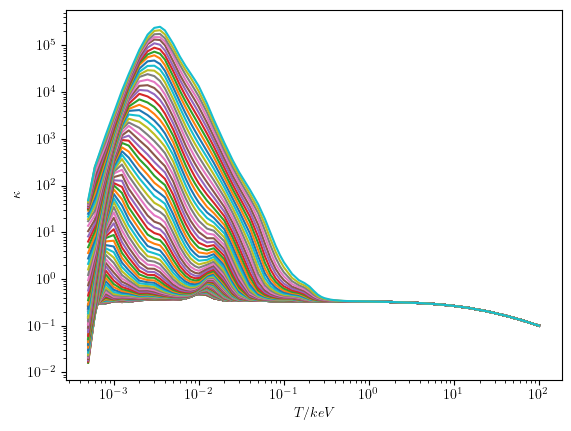

In [7]:
plt.plot(tgrid,ross_table)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$T/keV$')
plt.ylabel('$\\kappa$')

In [8]:
#now load multi-group opacity data
input_file="./multi_0_0.7_0.28_0.020000000000000018.dat"
output_file='multi_opacity_table.txt'

In [9]:
[tgrid,rhogrid,fregrid,multi_ross_table,multi_planck_table]=load_multi_opacity_data(input_file,output_file)

In [10]:
nt=len(tgrid)
nrho=len(rhogrid)
nfre=len(fregrid)
print(nfre,nt,nrho)

14 74 100


In [11]:
planck_plot=multi_planck_table.reshape(nfre,nt*nrho)

In [12]:
print(np.shape(multi_planck_table))
print(np.shape(multi_ross_table))

(14, 74, 100)
(14, 74, 100)


Text(0.5, 0, '$\\nu$')

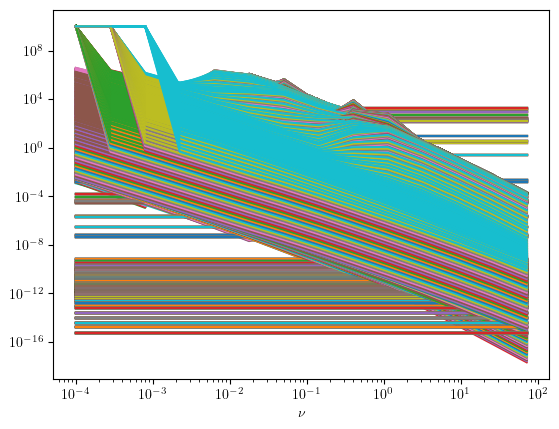

In [13]:
plt.plot(fregrid,planck_plot)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\nu$')

Text(0.5, 0, '$\\nu$')

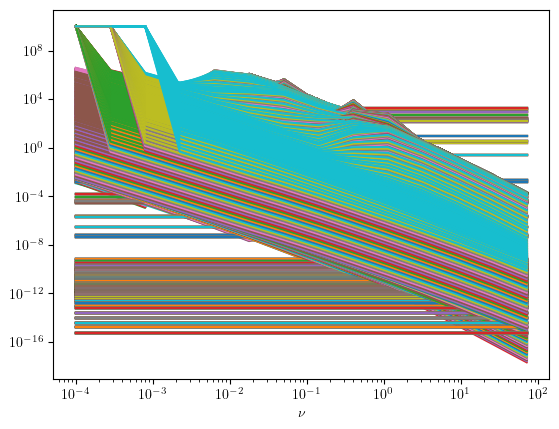

In [14]:
plt.plot(fregrid,planck_plot)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\nu$')

In [15]:
ross_plot=multi_ross_table.reshape(nfre,nt*nrho)

Text(0.5, 0, '$\\nu$')

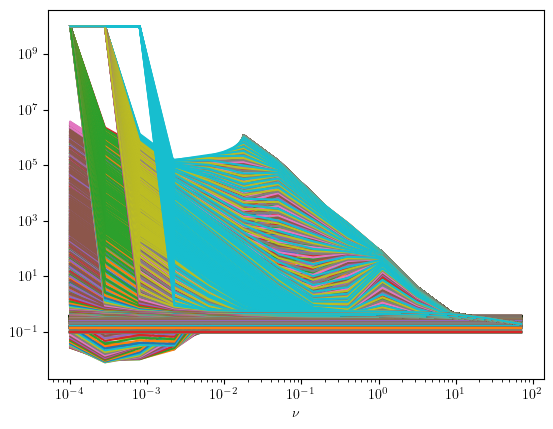

In [16]:
plt.plot(fregrid,ross_plot)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\nu$')

Text(0.5, 0, '$\\nu$')

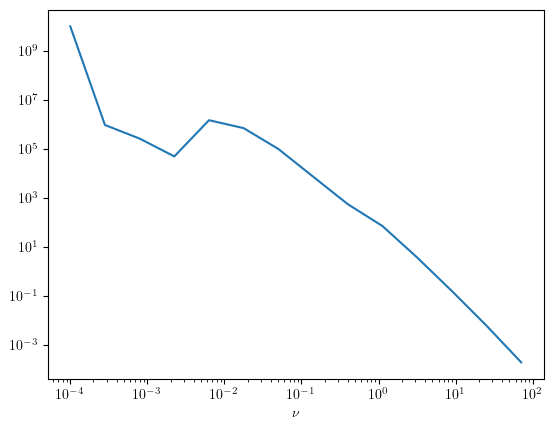

In [17]:
plt.plot(fregrid,multi_planck_table[:,6,90])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\nu$')

In [125]:
print(len(fregrid))

14


In [126]:
ratio=fregrid[1:]/fregrid[:-1]

In [127]:
print(ratio)

[2.8189    2.81883   2.8189025 2.8188312 2.8188598 2.8188562 2.8188162
 2.818908  2.8187635 2.8189018 2.818885  2.8188732 2.8188715]


In [18]:
print(rhogrid[49])

1.1365e-10


In [20]:
print(np.abs(tgrid-5).argmin())

65


Text(0.5, 0, '$T$')

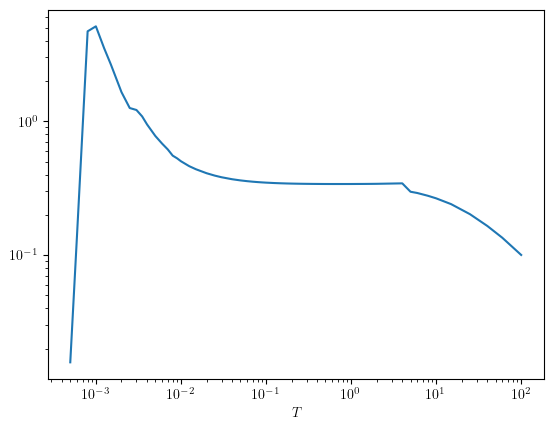

In [18]:
plt.plot(tgrid,multi_ross_table[2,:,49])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T$')

In [21]:
multi_ross_table[:,65,49]

array([0.29768, 0.29768, 0.29768, 0.29768, 0.29768, 0.29768, 0.29768,
       0.29768, 0.29768, 0.29768, 0.29768, 0.29768, 0.29768, 0.29768])

In [22]:
multi_planck_table[:,65,49]

array([2.3163e-13, 2.3163e-13, 2.3163e-13, 2.3163e-13, 2.3163e-13,
       2.3163e-13, 2.3163e-13, 2.3163e-13, 2.3163e-13, 2.3163e-13,
       2.3163e-13, 2.3163e-13, 2.3163e-13, 2.3163e-13])